Using glove data.

Contains word embeddings with certain vector length as encoded in the name of the files.  With this, one is able to kickstart a NN by loading the approved data and glue it into a layer.


In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
glove_dir = "data/glove"

In [2]:
embedding_index = {}
f = open(os.path.join(glove_dir, "glove.6B.100d.txt"))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float32")
    embedding_index[word] = coefs

In [3]:
from scipy.spatial import distance
vec_king = embedding_index["king"]
vec_man = embedding_index["man"]
vec_woman = embedding_index["woman"]
vec_queen_pred = vec_king + vec_woman - vec_man
vec_queen_true = embedding_index["queen"]
dist = distance.cosine(vec_king, vec_queen_true)
print(dist)
dist = distance.cosine(vec_queen_pred, vec_queen_true)
print(dist)
dist = distance.cosine(vec_king, embedding_index["cheese"])
print(dist)

0.2492309808731079
0.21655863523483276
0.8777846917510033


In [4]:
vec_a = embedding_index["mother"]
vec_b = embedding_index["daughter"]

print(distance.cosine(vec_a, vec_b))

0.09368908405303955


IMDB as text database

In [21]:
from keras.datasets import imdb
from keras import models, layers, preprocessing

max_words = 10000
max_len = 200

embedding_dim = 100

word_index = imdb.get_word_index()
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            
print(embedding_matrix.shape)

(10000, 100)


In [22]:
model = models.Sequential()
model.add(layers.Embedding(max_words, embedding_dim, input_length=max_len))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 20000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                640032    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 1,640,065
Trainable params: 1,640,065
Non-trainable params: 0
_________________________________________________________________


Loading the glove-data into the network and fix the layer so that it isn't trained.


In [23]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [24]:
model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [25]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_words)
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen = max_len)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen = max_len)

In [26]:
history = model.fit(
    x_train, y_train, # input, output of the nn
    batch_size = 32,
    epochs=10,
    validation_split=0.2
)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 7s 373us/step - loss: 0.7683 - acc: 0.4995 - val_loss: 0.6926 - val_acc: 0.5104
Epoch 2/10
20000/20000 [==============================] - 7s 371us/step - loss: 0.6992 - acc: 0.5054 - val_loss: 0.6925 - val_acc: 0.5082
Epoch 3/10
20000/20000 [==============================] - 7s 375us/step - loss: 0.6930 - acc: 0.5152 - val_loss: 0.7149 - val_acc: 0.5108
Epoch 4/10
20000/20000 [==============================] - 8s 395us/step - loss: 0.6844 - acc: 0.5373 - val_loss: 0.6972 - val_acc: 0.5152
Epoch 5/10
20000/20000 [==============================] - 8s 397us/step - loss: 0.6575 - acc: 0.5904 - val_loss: 0.7240 - val_acc: 0.5454
Epoch 6/10
20000/20000 [==============================] - 8s 388us/step - loss: 0.5926 - acc: 0.6671 - val_loss: 0.7257 - val_acc: 0.5600
Epoch 7/10
20000/20000 [==============================] - 8s 386us/step - loss: 0.5121 - acc: 0.7292 - val_loss: 0.7890 - v

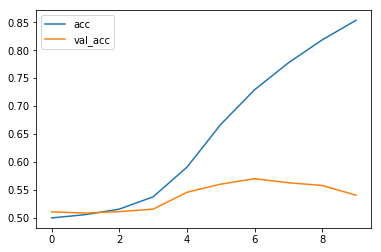

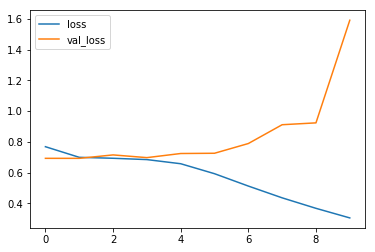

25000/25000 [==============================] - 3s 107us/step


[1.566641078262329, 0.54488]

In [28]:
def plot_history(history):
    plt.plot(history["acc"], label="acc")
    plt.plot(history["val_acc"], label="val_acc")
    plt.legend()
    plt.show()
    plt.close()
    
    plt.plot(history["loss"], label="loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.legend()
    plt.show()
    plt.close()

plot_history(history.history) 

model.evaluate(x_test, y_test)